In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road VGG19\Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Dell\AppData\Local\Temp\ipykernel_12232\791714145.py:2: SyntaxWarning: invalid escape sequence '\P'
  'E:\Python\Data Science\Road VGG19\Dataset',


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

48

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 0 2 0 1 0 2 0 0 1 0 0 2 2 2 1 1 0 2 0 0 2 1 0 1 0 2 2 0 0 0]


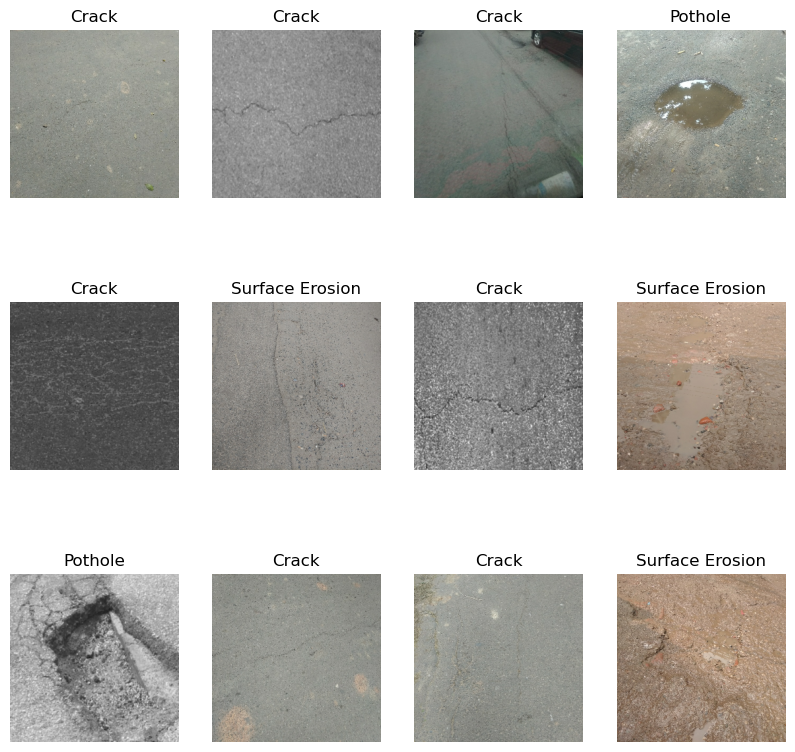

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [9]:
train_data = dataset.take(38)
len(train_data)

38

In [10]:
test_data = dataset.skip(38)
len(test_data)

10

In [11]:
validation_size = 0.1
len(dataset)*validation_size

4.800000000000001

In [12]:
validation_data  = test_data.take(4)
len(validation_data)

4

In [13]:
test_data = test_data.skip(4)
len(test_data)

6

In [14]:
# Dataset split function
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds


In [15]:
train_data, validation_data, test_data = get_dataset_partition(dataset)

In [16]:
len(train_data)
len(validation_data)
len(test_data)

6

In [17]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
# Model builders
def build_vgg19_model():
    base = tf.keras.applications.VGG19(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [21]:
def build_resnet50_model():
    base = tf.keras.applications.ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [22]:
def build_efficientnet_model():
    base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [23]:
def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [24]:
#model = build_vgg19_model()
model = build_mobilenet_model()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12232\3736113410.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')


In [25]:
# n_classes = 3
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])
# model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6729 - loss: 0.7727 - val_accuracy: 0.8525 - val_loss: 0.3353
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8366 - loss: 0.4372 - val_accuracy: 0.8852 - val_loss: 0.2969
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8477 - loss: 0.3955 - val_accuracy: 0.9016 - val_loss: 0.2756
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8512 - loss: 0.3779 - val_accuracy: 0.8689 - val_loss: 0.3323
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8698 - loss: 0.3387 - val_accuracy: 0.8770 - val_loss: 0.2852
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8693 - loss: 0.3352 - val_accuracy: 0.8525 - val_loss: 0.3028
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8958 - loss: 0.2982 - val_accuracy: 0.8934 - val_loss: 0.2847
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8797 - loss: 0.3105 - val_accuracy: 0.8852 - val_loss:

In [ ]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9121 - loss: 0.1733


[0.20702260732650757, 0.8958333134651184]

In [ ]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.7727272510528564,
 0.8223140239715576,
 0.8380165100097656,
 0.8371900916099548,
 0.8595041036605835,
 0.8578512668609619,
 0.8694214820861816,
 0.871074378490448,
 0.8661156892776489,
 0.8776859641075134,
 0.8735536932945251,
 0.8727272748947144,
 0.8834710717201233,
 0.8735536932945251,
 0.8809917569160461,
 0.8818181753158569,
 0.8909090757369995,
 0.8884297609329224,
 0.8826446533203125,
 0.9008264541625977,
 0.9057851433753967,
 0.8991735577583313,
 0.9090909361839294,
 0.9049586653709412,
 0.9008264541625977,
 0.8999999761581421,
 0.913223147392273,
 0.9074380397796631,
 0.910743772983551,
 0.9099173545837402,
 0.9066115617752075,
 0.9066115617752075,
 0.9173553586006165,
 0.9206611514091492,
 0.9099173545837402,
 0.918181836605072,
 0.9198347330093384,
 0.9173553586006165,
 0.9140495657920837,
 0.9190082550048828,
 0.9314049482345581,
 0.9214876294136047,
 0.910743772983551,
 0.9231404662132263,
 0.9247933626174927,
 0.9123966693878174,
 0.918181836605072,
 0.9256198406219482

In [ ]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
F1 Score (macro): 0.893211513901169
F1 Score (weighted): 0.895203973867767

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.98      0.90      0.94        61
        Pothole       1.00      0.74      0.85        50
Surface Erosion       0.81      0.99      0.89        81

       accuracy                           0.90       192
      macro avg       0.93      0.88      0.89       192
   weighted avg       0.91      0.90      0.90       192



In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

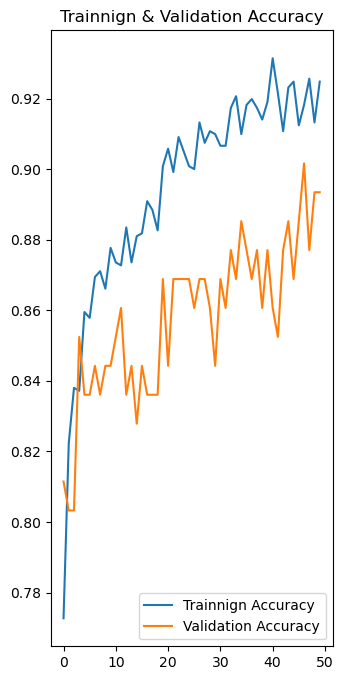

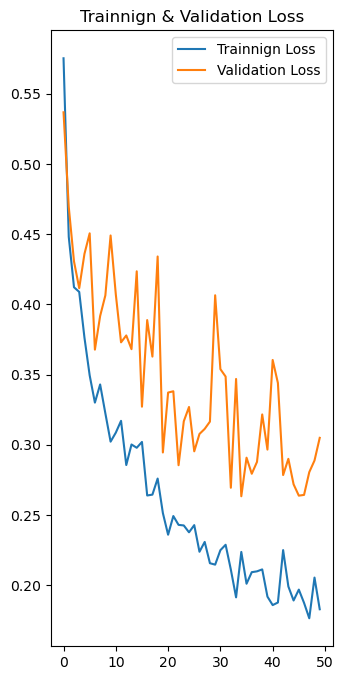

In [ ]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [ ]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8899 - loss: 0.2124


[0.20702259242534637, 0.8958333134651184]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label:  Pothole


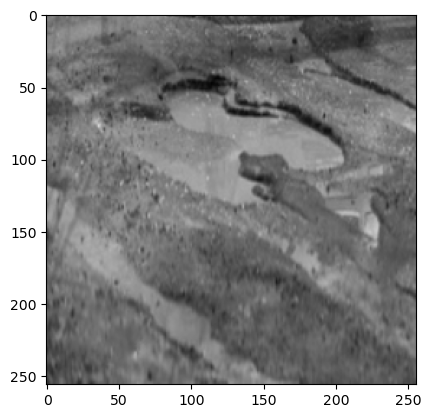

In [ ]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->99.41 Light:-> Normal lighting
Confidence:->89.1 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->90.42 Light:-> Normal lighting
Confidence:->83.32 Light:-> Low light
Confidence:->99.96 Light:-> Normal lighting
Confidence:->99.99 Light:-> Normal lighting
Confidence:->99.88 Light:-> Normal lighting
Confidence:->99.93 Light:-> Normal lighting


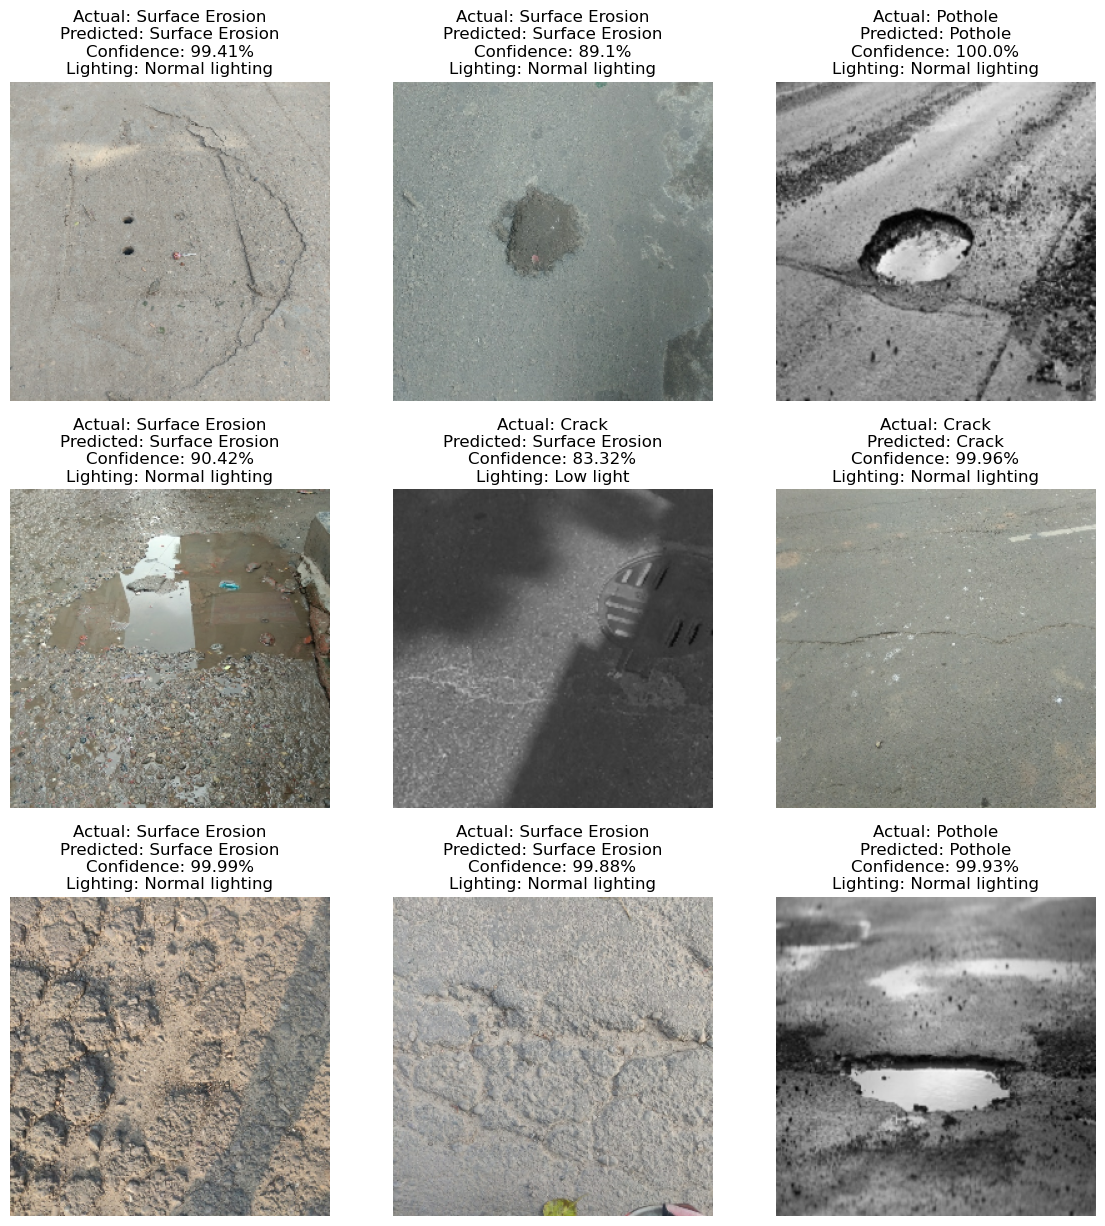

In [ ]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [ ]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Pothole, Confidence: 100.0
